In [1]:
print('Hello')

Hello


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb

import os
import joblib

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('mirichoi0218/insurance',unzip=True,path='./dataset')

Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance


In [5]:
df = pd.read_csv('./dataset/insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [6]:
df.shape

(1338, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
df.isna().sum().sum()

np.int64(0)

In [9]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [13]:
df.columns = df.columns.str.strip()

# Univariate analysis

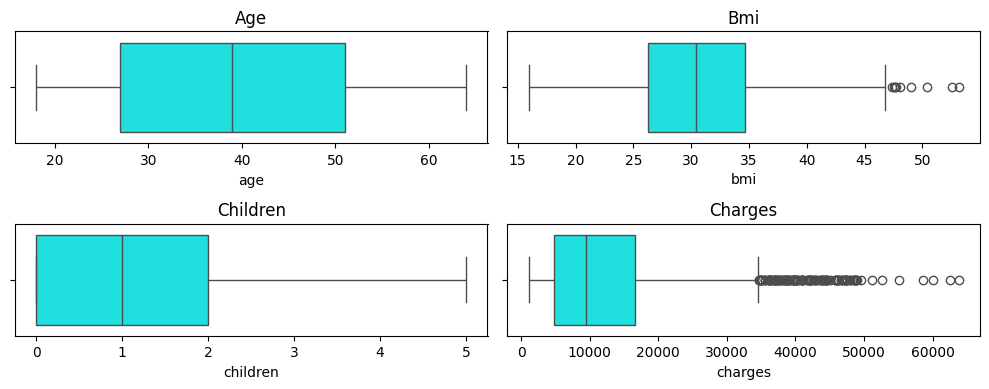

In [14]:
total=len(df.select_dtypes(include='number').columns)
fig,axes = plt.subplots(2,2,figsize=(10,4))
axes = axes.flatten()
for i,col in enumerate(df.select_dtypes(include='number').columns):
    sns.boxplot(x=df[col],ax=axes[i],orient='h',color='cyan')
    axes[i].set_title(col.title())
plt.tight_layout()
plt.show()


In [15]:
# we can see some outliners for bmi and a lot for charges(Target Variable)

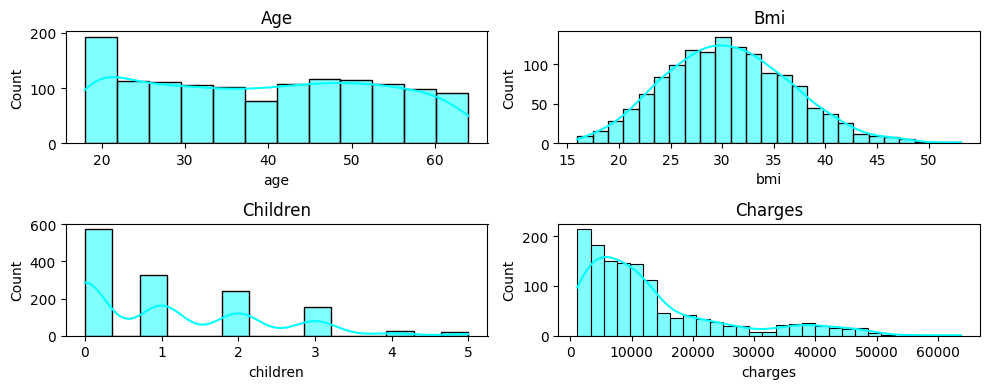

In [16]:
total=len(df.select_dtypes(include='number').columns)
fig,axes = plt.subplots(2,2,figsize=(10,4))
axes = axes.flatten()
for i,col in enumerate(df.select_dtypes(include='number').columns):
    sns.histplot(x=df[col],ax=axes[i],color='cyan',kde=True)
    axes[i].set_title(col.title())
plt.tight_layout()
plt.show()


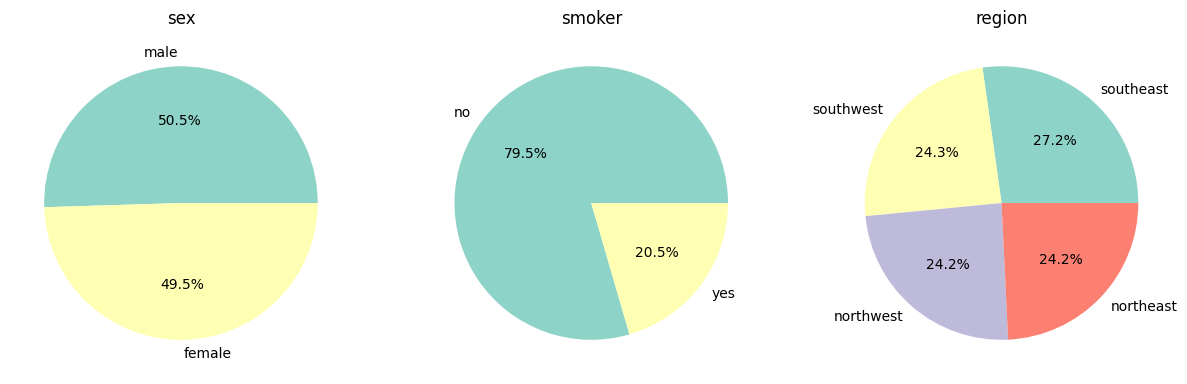

In [17]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
axes = axes.flatten()
for i, col in enumerate(df.select_dtypes(exclude='number').columns):
    counts = df[col].value_counts()
    axes[i].pie(counts.values, labels=counts.index, autopct='%1.1f%%',colors=plt.cm.Set3.colors[:len(counts)])
    axes[i].set_title(f'{col}')

In [18]:
df['sex'].replace(['male','female'],[1,0],inplace=True)
df['smoker'].replace(['yes','no'],[1,0],inplace=True)

In [19]:
skew = df.select_dtypes(include='number').skew()
skew.sort_values(ascending=False)

charges     1.515391
smoker      1.463601
children    0.937421
bmi         0.283914
age         0.054781
sex        -0.019469
dtype: float64

### No Skewness as charges is our target variable and smoker is the object variable

# Bivariate Analysis

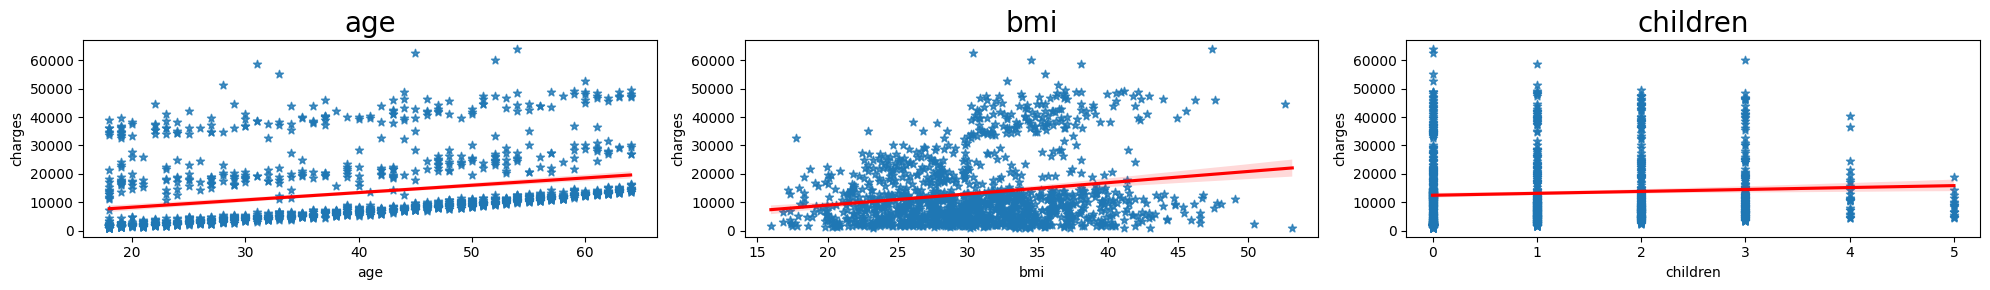

In [20]:
features = df.drop(columns=['charges'])
target = df['charges']

fig,axes = plt.subplots(nrows=1, ncols=3,figsize=(20,3))
axes= axes.flatten()

for i,col in enumerate(['age', 'bmi', 'children']):
    sns.regplot(data=df,x=col,y='charges',ax=axes[i], line_kws={'color': 'red'} ,marker='*')
    axes[i].set_title(col, fontsize=20)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [21]:
# Correlation matrix of numeric features
corr = df.select_dtypes(include=['number']).corr()
corr

,age,sex,bmi,children,smoker,charges
age,1.000000,-0.019814,0.109344,0.041536,-0.025587,0.298308
sex,-0.019814,1.000000,0.046397,0.017848,0.076596,0.058044
bmi,0.109344,0.046397,1.000000,0.012755,0.003746,0.198401
children,0.041536,0.017848,0.012755,1.000000,0.007331,0.067389
smoker,-0.025587,0.076596,0.003746,0.007331,1.000000,0.787234
charges,0.298308,0.058044,0.198401,0.067389,0.787234,1.000000


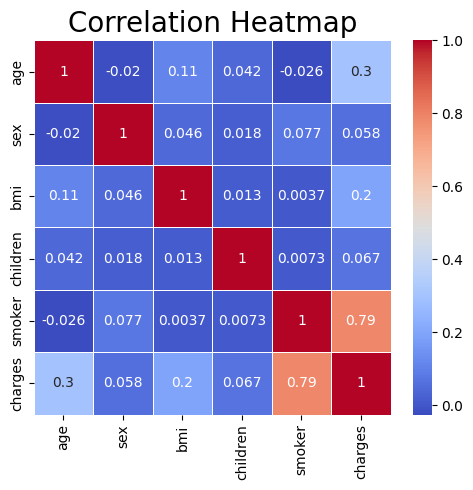

In [22]:
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=20)
plt.tight_layout()
plt.show()

In [23]:
df.shape

(1337, 7)

In [24]:

for i in ['age', 'bmi', 'children']:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[i] < lower_bound) | (df[i] > upper_bound)]

    print("Number of outliers in column :",i,' is ', outliers.shape[0])
    if len(outliers[[i]])>1:

        print(outliers[[i]])
        # Removing the outliers  rows (Tested The Model Before Removing little bit improvement in accuracy)
        df = df.drop(index=outliers.index)

Number of outliers in column : age  is  0
Number of outliers in column : bmi  is  9
        bmi
116   49.06
286   48.07
401   47.52
543   47.41
847   50.38
860   47.60
1047  52.58
1088  47.74
1317  53.13
Number of outliers in column : children  is  0


In [25]:
df.shape

(1328, 7)

#### Label Encoding 'Region' Column

In [26]:
le = LabelEncoder()
df['region'] = le.fit_transform(df['region'])

# Model Building

In [27]:
x = df.drop(columns=['charges'])
y = df['charges']

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, random_state=7)

In [29]:
x_train.shape,x_test.shape,y_train.shape, y_test.shape

((1062, 6), (266, 6), (1062,), (266,))

In [30]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

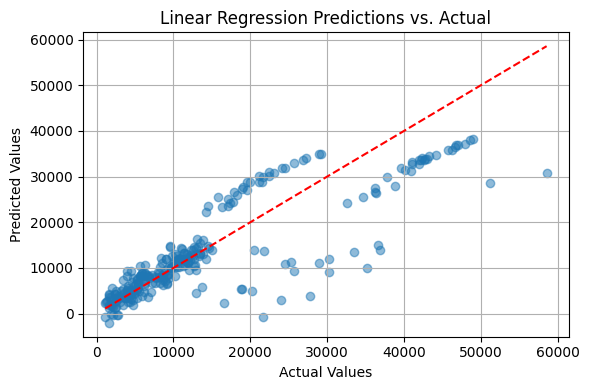

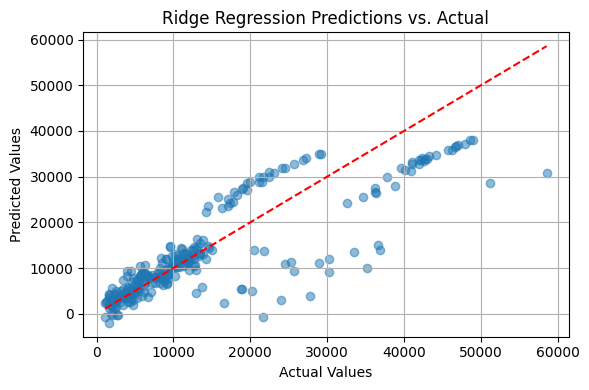

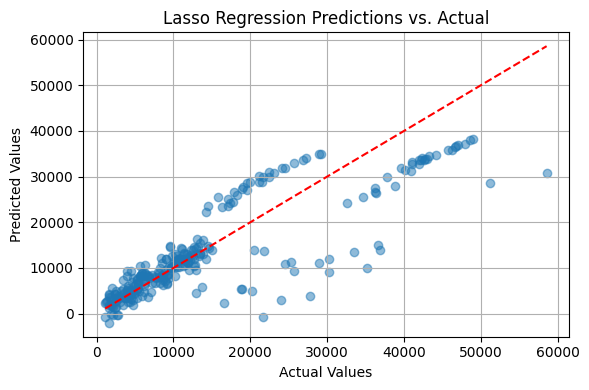

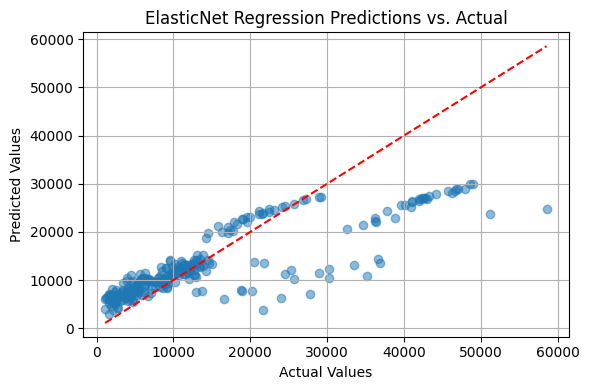

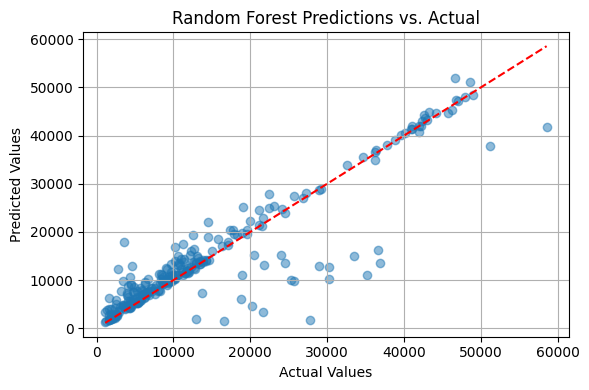

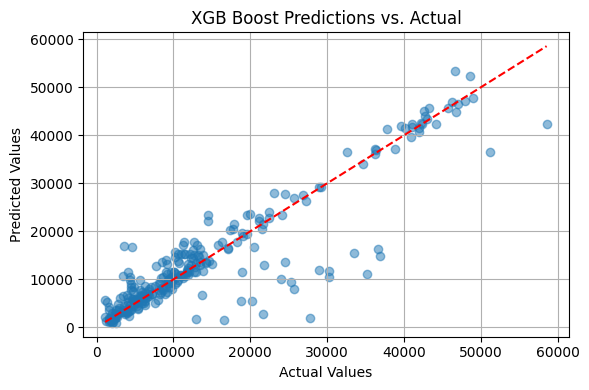

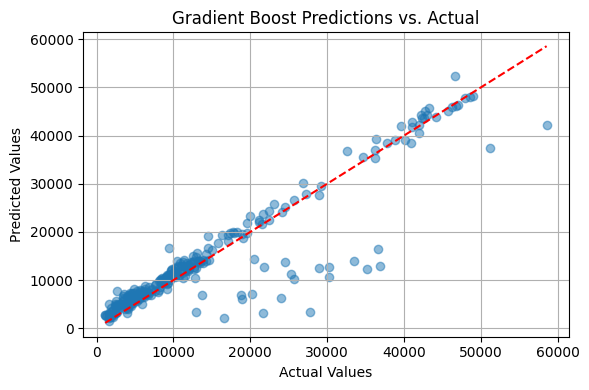

                   Model  Train R2   Test R2    Train MAE     Test MAE
6         Gradient Boost  0.904312  0.842747  1980.803029  2611.021906
4          Random Forest  0.975884  0.830852   978.401861  2641.912637
5              XGB Boost  0.994853  0.820718   435.788083  2854.409673
0      Linear Regression  0.757811  0.708646  3989.970590  4377.974009
2       Lasso Regression  0.757811  0.708626  3989.882067  4377.834390
1       Ridge Regression  0.757810  0.708602  3991.122518  4378.442005
3  ElasticNet Regression  0.672531  0.617151  4923.509624  5174.343505


In [31]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(max_iter=10000),
    'ElasticNet Regression': ElasticNet(max_iter=10000),
    'Random Forest': RandomForestRegressor(random_state=7),
    'XGB Boost': xgb.XGBRegressor(random_state=7),
    'Gradient Boost': GradientBoostingRegressor(random_state=7)
}

results = []

for name, model in models.items():
    if name in ['Random Forest', 'XGB Boost', 'Gradient Boost']:
        X_train_use = x_train
        X_test_use = x_test
    else:
        X_train_use = x_train_scaled
        X_test_use = x_test_scaled

    model.fit(X_train_use, y_train)
    
    y_pred_train = model.predict(X_train_use)
    y_pred_test = model.predict(X_test_use)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'Model': name,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Train MAE': train_mae,
        'Test MAE': test_mae
        
    })
    
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} Predictions vs. Actual")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='Test R2', ascending=False)

print(results_df)


# Gradient Boost is performing best. Let's tune it.

In [32]:
gbr = GradientBoostingRegressor(random_state=7)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Best CV R² Score: 0.8590795027323977


In [33]:
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)
n = len(y_test)
p = x_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")

Test MAE: 2586.44
Test MSE: 25158735.95
Test RMSE: 5015.85
Test R²: 0.8447
Adjusted R²: 0.8411


In [34]:
cv_scores = cross_val_score(best_model, x, y, cv=5, scoring='r2', n_jobs=-1)
print(f"CV R² scores: {cv_scores}")
print(f"Mean CV R² score: {cv_scores.mean():.4f}")

CV R² scores: [0.88350566 0.80541279 0.89391037 0.84862748 0.86753194]
Mean CV R² score: 0.8598


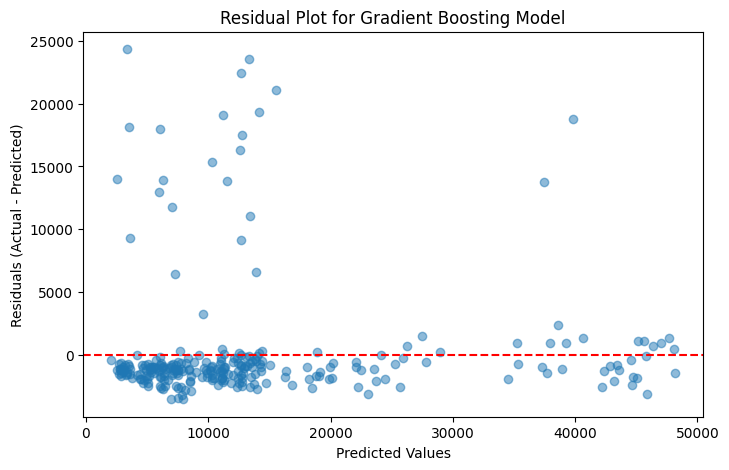

In [35]:
y_pred = best_model.predict(x_test)
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for Gradient Boosting Model')
plt.show()

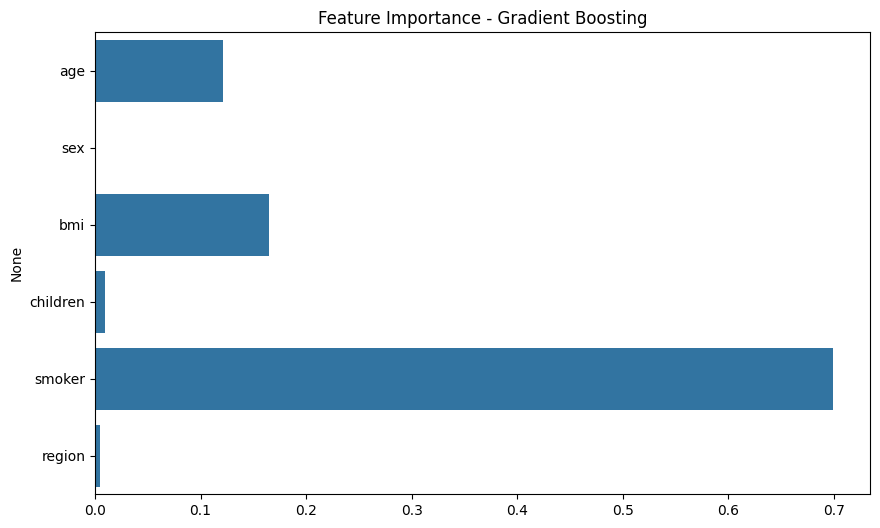

In [36]:
importances = best_model.feature_importances_
features = x.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance - Gradient Boosting')
plt.show()


In [39]:
os.makedirs('./model', exist_ok=True)
joblib.dump(best_model,'./model/model.pkl')

['./model/model.pkl']